In [ ]:
!pip install -q tensorflow-probability

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
import pandas as pd
import cv2, os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Loading**

In [ ]:
x_train = np.load('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/TRAIN_Images.npy')/255.0
x_test = np.load('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/TEST_Images.npy')/255.0
y_train = np.load('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/TRAIN_Masks.npy')/255.0
y_test = np.load('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/TEST_Masks.npy')/255.0

# **Student with BCE**

In [ ]:
from tensorflow import keras
from keras import layers

In [ ]:
from keras import layers

def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, (3,3), padding = "same", activation = "relu")(x)
   x = layers.Conv2D(n_filters, (3,3), padding = "same", activation = "relu")(x)
   x=keras.layers.BatchNormalization()(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x


In [ ]:
inputs = layers.Input(shape=(128,128,3))
f1, p1 = downsample_block(inputs, 8)
f2, p2 = downsample_block(p1, 16)
f3, p3 = downsample_block(p2, 32)
f4, p4 = downsample_block(p3, 64)

bottleneck = double_conv_block(p4, 128)

u6 = upsample_block(bottleneck, f4, 64)
u7 = upsample_block(u6, f3, 32)
u8 = upsample_block(u7, f2, 16)
u9 = upsample_block(u8, f1,8)

outputs1 = layers.Conv2D(3, 1, padding="same",activation='sigmoid',name='Output_1')(u9)
MODEL = keras.models.Model([inputs], [outputs1])

In [ ]:
from keras import backend as K
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
import keras.backend as K

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

LOG = keras.callbacks.CSVLogger('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Crack_Segment_UNet_BCE.csv', separator=",", append=False)

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

import keras.backend as K

def pixel_wise_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def mean_pixel_accuracy(y_true, y_pred):
    class_accuracy = K.mean(K.cast(K.equal(K.round(y_true), K.round(y_pred)), dtype='float32'), axis=0)
    return K.mean(class_accuracy)

def intersection_over_union(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(iou, axis=-1)


import tensorflow as tf

def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1-((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

# Custom Focal Loss function
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Compute binary cross-entropy loss for each channel
    binary_ce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
    # Modify the loss for each channel
    focal_loss = alpha * (1 - tf.exp(-binary_ce)) ** gamma * binary_ce
    # Sum the loss across channels
    focal_loss = tf.reduce_sum(focal_loss, axis=-1)
    return tf.reduce_mean(focal_loss)

# Custom Tversky Loss function
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    true_positives = tf.reduce_sum(y_true * y_pred)
    false_positives = tf.reduce_sum((1 - y_true) * y_pred)
    false_negatives = tf.reduce_sum(y_true * (1 - y_pred))
    tversky = (true_positives + 1e-5) / (true_positives + alpha * false_positives + beta * false_negatives + 1e-5)
    return 1 - tversky

In [ ]:
MODEL.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy',
        metrics=[dice_coef, keras.metrics.Recall(), keras.metrics.Precision(), get_f1, pixel_wise_accuracy, intersection_over_union])
model_history = MODEL.fit(x_train, y_train, epochs=30, batch_size=16, validation_data=(x_test, y_test), callbacks= [LOG])

In [ ]:
MODEL.save('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Student_UNet_BCE.h5')

# **Results Visualization**

In [ ]:
from keras.models import load_model

from keras import backend as K
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model

smooth = 1.
def dice_score(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def pixel_wise_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def mean_pixel_accuracy(y_true, y_pred):
    class_accuracy = K.mean(K.cast(K.equal(K.round(y_true), K.round(y_pred)), dtype='float32'), axis=0)
    return K.mean(class_accuracy)

def matthews_correlation_coefficient(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    numerator = intersection
    denominator = K.sqrt(K.sum(y_true) * K.sum(y_pred))
    return K.cast(numerator / denominator, dtype='float32')

def intersection_over_union(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(iou, axis=-1)

def jaccard_index(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true + y_pred, axis=-1) - intersection
    jaccard = (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(jaccard, axis=-1)

# Custom Tversky Loss function
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    true_positives = tf.reduce_sum(y_true * y_pred)
    false_positives = tf.reduce_sum((1 - y_true) * y_pred)
    false_negatives = tf.reduce_sum(y_true * (1 - y_pred))
    tversky = (true_positives + 1e-5) / (true_positives + alpha * false_positives + beta * false_negatives + 1e-5)
    return 1 - tversky

Tvisky = load_model('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Student_UNet_TVERSKY.h5', custom_objects = {
    "tversky_loss":tversky_loss, "dice_coef":dice_score, "pixel_wise_accuracy":pixel_wise_accuracy,
    'mean_pixel_accuracy':mean_pixel_accuracy, "intersection_over_union":intersection_over_union, "get_f1":get_f1 })

In [ ]:
preds = Tvisky.predict(x_train[3000:3500])

16/16 [==============================] - 14s 875ms/step


In [ ]:
get_it = x_train[3000:3500]

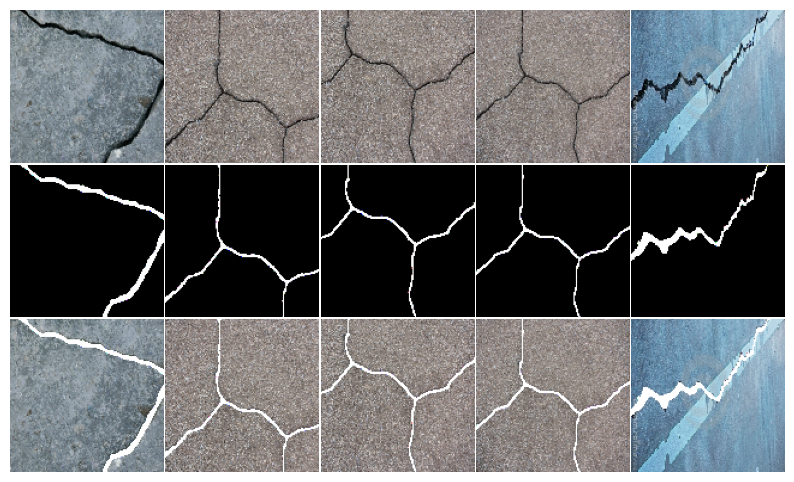

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Set figure size
plt.rcParams['figure.figsize'] = (10, 6)

# Create a new figure
plt.figure()
sns.set_style("whitegrid", {'axes.grid' : False})

# Set only vertical spacing to zero
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Iterate through each column
for i in range(5):
    # Plot the original images
    plt.subplot(3, 5, i + 1)
    plt.imshow(get_it[i+6], aspect='auto')
    plt.axis('off')

    # Plot the predicted masks
    plt.subplot(3, 5, i + 6)
    plt.imshow(preds[i+6], aspect='auto')
    plt.axis('off')

    # Plot the extracted masks
    plt.subplot(3, 5, i + 11)
    plt.imshow(get_it[i+6] + preds[i+6], aspect='auto')
    plt.axis('off')

plt.savefig('Tversky_STUDENT.png', format='png', dpi=600, bbox_inches='tight')

plt.show()

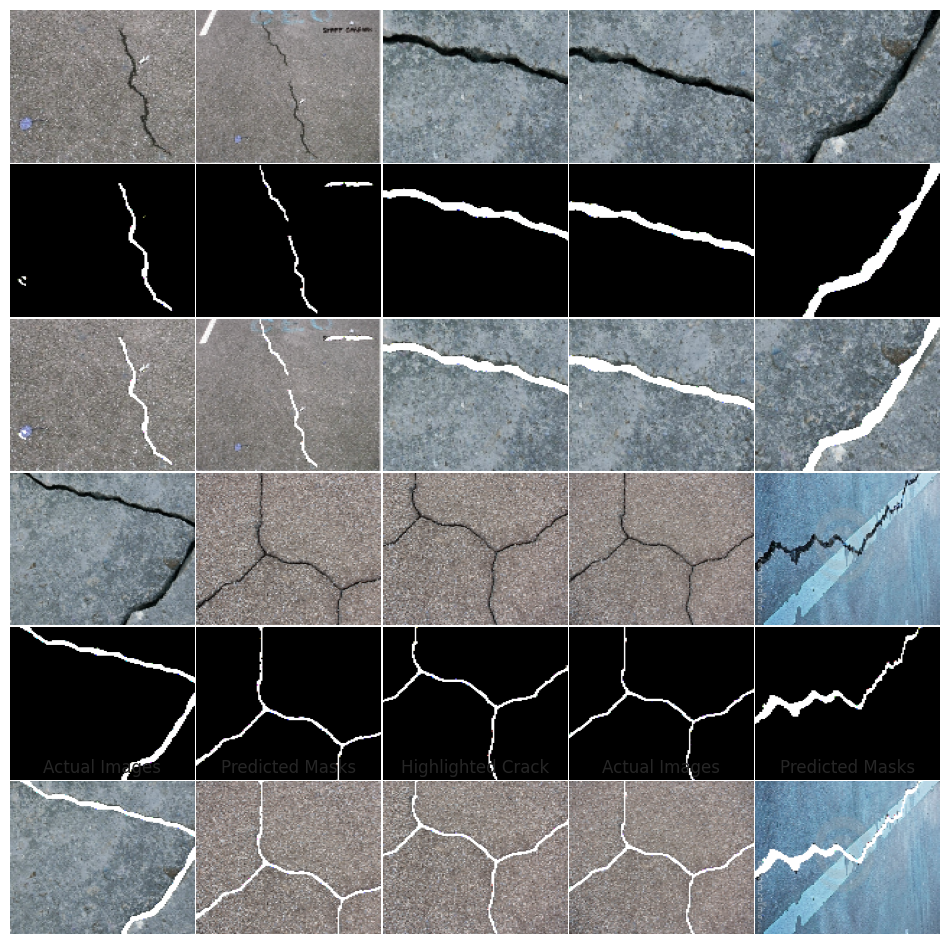

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.rcParams['figure.figsize'] = (12, 12)

# Create a new figure
plt.figure()
sns.set_style("whitegrid", {'axes.grid' : False})

# Set only vertical spacing to zero
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Iterate through each column
for i in range(5):
    # Plot the original images
    plt.subplot(6, 5, i + 1)
    plt.imshow(get_it[i], aspect='auto')
    plt.axis('off')

    # Plot the predicted masks
    plt.subplot(6, 5, i + 6)
    plt.imshow(preds[i], aspect='auto')
    plt.axis('off')

    # Plot the extracted masks
    plt.subplot(6, 5, i + 11)
    plt.imshow(get_it[i] + preds[i], aspect='auto')
    plt.axis('off')

    plt.subplot(6, 5, i + 16)
    plt.imshow(get_it[i+6], aspect='auto')
    plt.axis('off')

    # Plot the predicted masks
    plt.subplot(6, 5, i + 21)
    plt.imshow(preds[i+6], aspect='auto')
    plt.axis('off')

    # Plot the extracted masks
    plt.subplot(6, 5, i + 26)
    plt.imshow(get_it[i+6] + preds[i+6], aspect='auto')
    plt.axis('off')

plt.savefig('BCE_STUDENT.png', format='png', dpi=300)

plt.show()


4/4 [==============================] - 3s 419ms/step


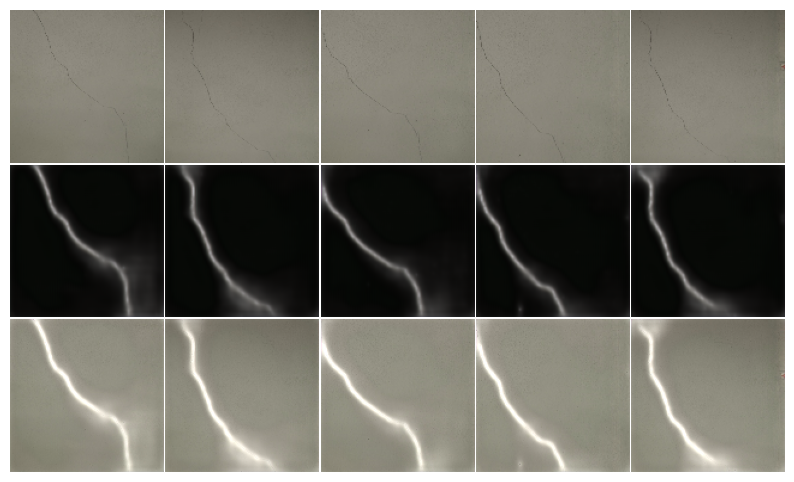

In [ ]:
from keras.models import load_model

from keras import backend as K
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model

smooth = 1.
def dice_score(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def pixel_wise_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def mean_pixel_accuracy(y_true, y_pred):
    class_accuracy = K.mean(K.cast(K.equal(K.round(y_true), K.round(y_pred)), dtype='float32'), axis=0)
    return K.mean(class_accuracy)

def matthews_correlation_coefficient(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    numerator = intersection
    denominator = K.sqrt(K.sum(y_true) * K.sum(y_pred))
    return K.cast(numerator / denominator, dtype='float32')

def intersection_over_union(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(iou, axis=-1)

def jaccard_index(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true + y_pred, axis=-1) - intersection
    jaccard = (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(jaccard, axis=-1)

# Custom Tversky Loss function
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    true_positives = tf.reduce_sum(y_true * y_pred)
    false_positives = tf.reduce_sum((1 - y_true) * y_pred)
    false_negatives = tf.reduce_sum(y_true * (1 - y_pred))
    tversky = (true_positives + 1e-5) / (true_positives + alpha * false_positives + beta * false_negatives + 1e-5)
    return 1 - tversky

def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1-((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

# Custom Focal Loss function
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Compute binary cross-entropy loss for each channel
    binary_ce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
    # Modify the loss for each channel
    focal_loss = alpha * (1 - tf.exp(-binary_ce)) ** gamma * binary_ce
    # Sum the loss across channels
    focal_loss = tf.reduce_sum(focal_loss, axis=-1)
    return tf.reduce_mean(focal_loss)

focal = load_model('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Student_UNet_FOCAL.h5', custom_objects = {
    "focal_loss":focal_loss, "dice_coef":dice_score, "pixel_wise_accuracy":pixel_wise_accuracy,
    'mean_pixel_accuracy':mean_pixel_accuracy, "intersection_over_union":intersection_over_union, "get_f1":get_f1 })

preds = focal.predict(x_train[4200:4300])
get_it = x_train[4200:4300]

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Set figure size
plt.rcParams['figure.figsize'] = (10, 6)

# Create a new figure
plt.figure()
sns.set_style("whitegrid", {'axes.grid' : False})

# Set only vertical spacing to zero
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Iterate through each column
for i in range(5):
    # Plot the original images
    plt.subplot(3, 5, i + 1)
    plt.imshow(get_it[i+6], aspect='auto')
    plt.axis('off')

    # Plot the predicted masks
    plt.subplot(3, 5, i + 6)
    plt.imshow(preds[i+6], aspect='auto')
    plt.axis('off')

    # Plot the extracted masks
    plt.subplot(3, 5, i + 11)
    plt.imshow(get_it[i+6] + preds[i+6], aspect='auto')
    plt.axis('off')

plt.savefig('focal_STUDENT.png', format='png', dpi=600, bbox_inches='tight')

plt.show()

4/4 [==============================] - 2s 437ms/step


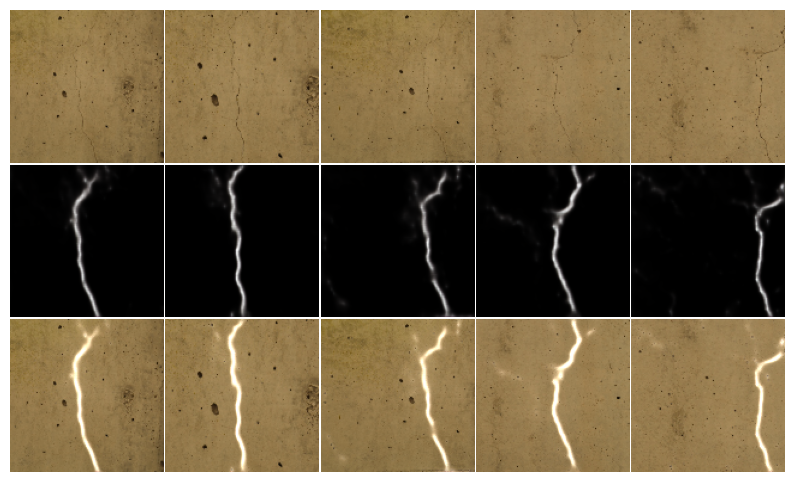

In [ ]:
from keras.models import load_model

from keras import backend as K
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model

smooth = 1.
def dice_score(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def pixel_wise_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def mean_pixel_accuracy(y_true, y_pred):
    class_accuracy = K.mean(K.cast(K.equal(K.round(y_true), K.round(y_pred)), dtype='float32'), axis=0)
    return K.mean(class_accuracy)

def matthews_correlation_coefficient(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    numerator = intersection
    denominator = K.sqrt(K.sum(y_true) * K.sum(y_pred))
    return K.cast(numerator / denominator, dtype='float32')

def intersection_over_union(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(iou, axis=-1)

def jaccard_index(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true + y_pred, axis=-1) - intersection
    jaccard = (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(jaccard, axis=-1)

# Custom Tversky Loss function
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    true_positives = tf.reduce_sum(y_true * y_pred)
    false_positives = tf.reduce_sum((1 - y_true) * y_pred)
    false_negatives = tf.reduce_sum(y_true * (1 - y_pred))
    tversky = (true_positives + 1e-5) / (true_positives + alpha * false_positives + beta * false_negatives + 1e-5)
    return 1 - tversky

def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1-((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

# Custom Focal Loss function
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Compute binary cross-entropy loss for each channel
    binary_ce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
    # Modify the loss for each channel
    focal_loss = alpha * (1 - tf.exp(-binary_ce)) ** gamma * binary_ce
    # Sum the loss across channels
    focal_loss = tf.reduce_sum(focal_loss, axis=-1)
    return tf.reduce_mean(focal_loss)

BCE = load_model('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Student_UNet_BCE.h5', custom_objects = {
   "dice_coef":dice_score, "pixel_wise_accuracy":pixel_wise_accuracy,
    'mean_pixel_accuracy':mean_pixel_accuracy, "intersection_over_union":intersection_over_union, "get_f1":get_f1 })

preds = BCE.predict(x_train[4900:5000])
get_it = x_train[4900:5000]

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Set figure size
plt.rcParams['figure.figsize'] = (10, 6)

# Create a new figure
plt.figure()
sns.set_style("whitegrid", {'axes.grid' : False})

# Set only vertical spacing to zero
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Iterate through each column
for i in range(5):
    # Plot the original images
    plt.subplot(3, 5, i + 1)
    plt.imshow(get_it[i+6], aspect='auto')
    plt.axis('off')

    # Plot the predicted masks
    plt.subplot(3, 5, i + 6)
    plt.imshow(preds[i+6], aspect='auto')
    plt.axis('off')

    # Plot the extracted masks
    plt.subplot(3, 5, i + 11)
    plt.imshow(get_it[i+6] + preds[i+6], aspect='auto')
    plt.axis('off')

plt.savefig('BCE_STUDENT.png', format='png', dpi=600, bbox_inches='tight')

plt.show()

4/4 [==============================] - 2s 390ms/step


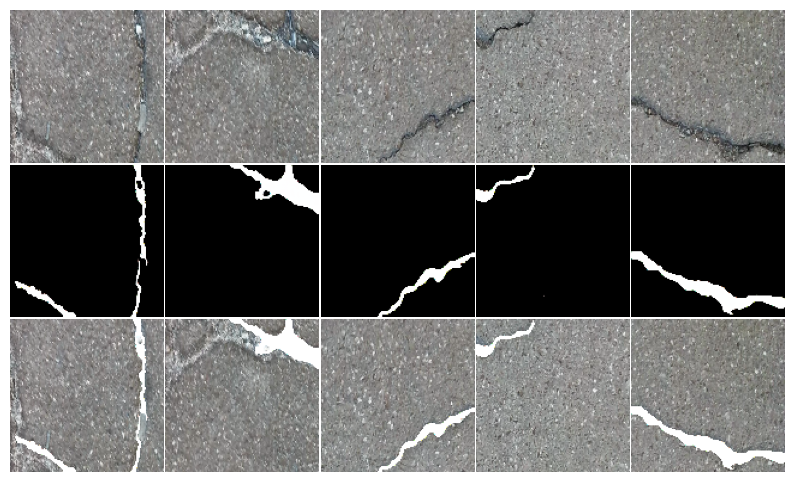

In [ ]:
from keras.models import load_model

from keras import backend as K
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model

smooth = 1.
def dice_score(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def pixel_wise_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def mean_pixel_accuracy(y_true, y_pred):
    class_accuracy = K.mean(K.cast(K.equal(K.round(y_true), K.round(y_pred)), dtype='float32'), axis=0)
    return K.mean(class_accuracy)

def matthews_correlation_coefficient(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    numerator = intersection
    denominator = K.sqrt(K.sum(y_true) * K.sum(y_pred))
    return K.cast(numerator / denominator, dtype='float32')

def intersection_over_union(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(iou, axis=-1)

def jaccard_index(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true + y_pred, axis=-1) - intersection
    jaccard = (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(jaccard, axis=-1)

# Custom Tversky Loss function
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    true_positives = tf.reduce_sum(y_true * y_pred)
    false_positives = tf.reduce_sum((1 - y_true) * y_pred)
    false_negatives = tf.reduce_sum(y_true * (1 - y_pred))
    tversky = (true_positives + 1e-5) / (true_positives + alpha * false_positives + beta * false_negatives + 1e-5)
    return 1 - tversky

def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1-((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

# Custom Focal Loss function
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Compute binary cross-entropy loss for each channel
    binary_ce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
    # Modify the loss for each channel
    focal_loss = alpha * (1 - tf.exp(-binary_ce)) ** gamma * binary_ce
    # Sum the loss across channels
    focal_loss = tf.reduce_sum(focal_loss, axis=-1)
    return tf.reduce_mean(focal_loss)

BCE = load_model('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Student_UNet_DICE.h5', custom_objects = {
   "dice_loss":dice_loss, "dice_coef":dice_score, "pixel_wise_accuracy":pixel_wise_accuracy,
    'mean_pixel_accuracy':mean_pixel_accuracy, "intersection_over_union":intersection_over_union, "get_f1":get_f1 })

preds = BCE.predict(x_train[900:1000])
get_it = x_train[900:1000]

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Set figure size
plt.rcParams['figure.figsize'] = (10, 6)

# Create a new figure
plt.figure()
sns.set_style("whitegrid", {'axes.grid' : False})

# Set only vertical spacing to zero
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Iterate through each column
for i in range(5):
    # Plot the original images
    plt.subplot(3, 5, i + 1)
    plt.imshow(get_it[i+6], aspect='auto')
    plt.axis('off')

    # Plot the predicted masks
    plt.subplot(3, 5, i + 6)
    plt.imshow(preds[i+6], aspect='auto')
    plt.axis('off')

    # Plot the extracted masks
    plt.subplot(3, 5, i + 11)
    plt.imshow(get_it[i+6] + preds[i+6], aspect='auto')
    plt.axis('off')

plt.savefig('DICE_STUDENT.png', format='png', dpi=600, bbox_inches='tight')

plt.show()

# **Dice Loss**

In [ ]:
from tensorflow import keras
from keras import layers

In [ ]:
from keras import layers

def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, (3,3), padding = "same", activation = "relu")(x)
   x = layers.Conv2D(n_filters, (3,3), padding = "same", activation = "relu")(x)
   x=keras.layers.BatchNormalization()(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x


In [ ]:
inputs = layers.Input(shape=(128,128,3))
f1, p1 = downsample_block(inputs, 8)
f2, p2 = downsample_block(p1, 16)
f3, p3 = downsample_block(p2, 32)
f4, p4 = downsample_block(p3, 64)

bottleneck = double_conv_block(p4, 128)

u6 = upsample_block(bottleneck, f4, 64)
u7 = upsample_block(u6, f3, 32)
u8 = upsample_block(u7, f2, 16)
u9 = upsample_block(u8, f1,8)

outputs1 = layers.Conv2D(3, 1, padding="same",activation='sigmoid',name='Output_1')(u9)
MODEL = keras.models.Model([inputs], [outputs1])

In [ ]:
from keras import backend as K
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
import keras.backend as K

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

LOG = keras.callbacks.CSVLogger('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Crack_Segment_UNet_DICE.csv', separator=",", append=False)

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

import keras.backend as K

def pixel_wise_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def mean_pixel_accuracy(y_true, y_pred):
    class_accuracy = K.mean(K.cast(K.equal(K.round(y_true), K.round(y_pred)), dtype='float32'), axis=0)
    return K.mean(class_accuracy)

def intersection_over_union(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(iou, axis=-1)


import tensorflow as tf

def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1-((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

# Custom Focal Loss function
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Compute binary cross-entropy loss for each channel
    binary_ce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
    # Modify the loss for each channel
    focal_loss = alpha * (1 - tf.exp(-binary_ce)) ** gamma * binary_ce
    # Sum the loss across channels
    focal_loss = tf.reduce_sum(focal_loss, axis=-1)
    return tf.reduce_mean(focal_loss)

# Custom Tversky Loss function
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    true_positives = tf.reduce_sum(y_true * y_pred)
    false_positives = tf.reduce_sum((1 - y_true) * y_pred)
    false_negatives = tf.reduce_sum(y_true * (1 - y_pred))
    tversky = (true_positives + 1e-5) / (true_positives + alpha * false_positives + beta * false_negatives + 1e-5)
    return 1 - tversky

In [ ]:
MODEL.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss = dice_loss,
        metrics=[dice_coef, keras.metrics.Recall(), keras.metrics.Precision(), get_f1, pixel_wise_accuracy, intersection_over_union])

model_history = MODEL.fit(x_train, y_train, epochs=30, batch_size=16, validation_data=(x_test, y_test), callbacks = [LOG])

Epoch 1/30
313/313 [==============================] - 42s 58ms/step - loss: 0.7691 - dice_coef: 0.2309 - recall: 0.7144 - precision: 0.2218 - get_f1: 0.3341 - pixel_wise_accuracy: 0.8271 - intersection_over_union: 0.0356 - val_loss: 0.8021 - val_dice_coef: 0.1978 - val_recall: 0.3000 - val_precision: 0.6073 - val_get_f1: 0.2312 - val_pixel_wise_accuracy: 0.9668 - val_intersection_over_union: 0.0142
Epoch 2/30
313/313 [==============================] - 12s 37ms/step - loss: 0.4636 - dice_coef: 0.5365 - recall: 0.5846 - precision: 0.6148 - get_f1: 0.5816 - pixel_wise_accuracy: 0.9569 - intersection_over_union: 0.0308 - val_loss: 0.8193 - val_dice_coef: 0.1806 - val_recall: 0.4550 - val_precision: 0.5380 - val_get_f1: 0.2727 - val_pixel_wise_accuracy: 0.9607 - val_intersection_over_union: 0.0208
Epoch 3/30
313/313 [==============================] - 12s 38ms/step - loss: 0.3938 - dice_coef: 0.6063 - recall: 0.5454 - precision: 0.7032 - get_f1: 0.6145 - pixel_wise_accuracy: 0.9649 - interse

In [ ]:
MODEL.save('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Student_UNet_DICE.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
preds = MODEL.predict(x_test[:50])

2/2 [==============================] - 1s 474ms/step


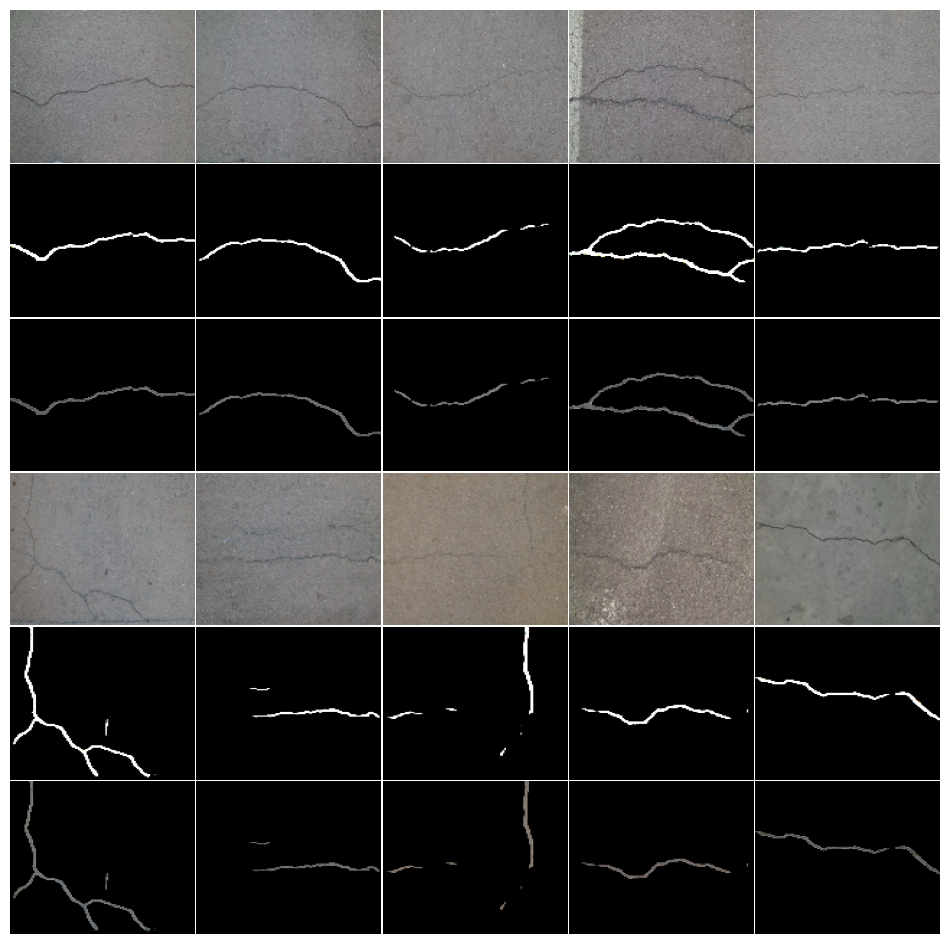

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.rcParams['figure.figsize'] = (12, 12)

# Create a new figure
plt.figure()
sns.set_style("whitegrid", {'axes.grid' : False})

# Set only vertical spacing to zero
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Iterate through each column
for i in range(5):
    # Plot the original images
    plt.subplot(6, 5, i + 1)
    plt.imshow(x_test[i], aspect='auto')
    plt.axis('off')

    # Plot the predicted masks
    plt.subplot(6, 5, i + 6)
    plt.imshow(preds[i], aspect='auto')
    plt.axis('off')

    # Plot the extracted masks
    plt.subplot(6, 5, i + 11)
    plt.imshow(x_test[i] * preds[i], aspect='auto')
    plt.axis('off')

    plt.subplot(6, 5, i + 16)
    plt.imshow(x_test[i+6], aspect='auto')
    plt.axis('off')

    # Plot the predicted masks
    plt.subplot(6, 5, i + 21)
    plt.imshow(preds[i+6], aspect='auto')
    plt.axis('off')

    # Plot the extracted masks
    plt.subplot(6, 5, i + 26)
    plt.imshow(x_test[i+6] * preds[i+6], aspect='auto')
    plt.axis('off')

plt.savefig('Dice_STUDENT.png', format='png', dpi=300)

plt.show()

# **Focal Loss**

In [ ]:
from tensorflow import keras
from keras import layers

In [ ]:
from keras import layers

def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, (3,3), padding = "same", activation = "relu")(x)
   x = layers.Conv2D(n_filters, (3,3), padding = "same", activation = "relu")(x)
   x=keras.layers.BatchNormalization()(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x


In [ ]:
inputs = layers.Input(shape=(128,128,3))
f1, p1 = downsample_block(inputs, 8)
f2, p2 = downsample_block(p1, 16)
f3, p3 = downsample_block(p2, 32)
f4, p4 = downsample_block(p3, 64)

bottleneck = double_conv_block(p4, 128)

u6 = upsample_block(bottleneck, f4, 64)
u7 = upsample_block(u6, f3, 32)
u8 = upsample_block(u7, f2, 16)
u9 = upsample_block(u8, f1,8)

outputs1 = layers.Conv2D(3, 1, padding="same",activation='sigmoid',name='Output_1')(u9)
MODEL = keras.models.Model([inputs], [outputs1])

In [ ]:
from keras import backend as K
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
import keras.backend as K

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

LOG = keras.callbacks.CSVLogger('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Crack_Segment_UNet_FOCAL.csv', separator=",", append=False)

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

import keras.backend as K

def pixel_wise_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def mean_pixel_accuracy(y_true, y_pred):
    class_accuracy = K.mean(K.cast(K.equal(K.round(y_true), K.round(y_pred)), dtype='float32'), axis=0)
    return K.mean(class_accuracy)

def intersection_over_union(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(iou, axis=-1)


import tensorflow as tf

def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1-((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

# Custom Focal Loss function
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Compute binary cross-entropy loss for each channel
    binary_ce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
    # Modify the loss for each channel
    focal_loss = alpha * (1 - tf.exp(-binary_ce)) ** gamma * binary_ce
    # Sum the loss across channels
    focal_loss = tf.reduce_sum(focal_loss, axis=-1)
    return tf.reduce_mean(focal_loss)

# Custom Tversky Loss function
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    true_positives = tf.reduce_sum(y_true * y_pred)
    false_positives = tf.reduce_sum((1 - y_true) * y_pred)
    false_negatives = tf.reduce_sum(y_true * (1 - y_pred))
    tversky = (true_positives + 1e-5) / (true_positives + alpha * false_positives + beta * false_negatives + 1e-5)
    return 1 - tversky

In [ ]:
MODEL.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss= focal_loss,
        metrics=[dice_coef, keras.metrics.Recall(), keras.metrics.Precision(), get_f1, pixel_wise_accuracy, intersection_over_union])

model_history = MODEL.fit(x_train, y_train, epochs=30, batch_size=16, validation_data=(x_test, y_test), callbacks = [LOG])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 [==============================] - 42s 63ms/step - loss: 3.3236 - dice_coef: 0.1140 - recall: 0.4631 - precision: 0.2006 - get_f1: 0.3446 - pixel_wise_accuracy: 0.8612 - intersection_over_union: 0.0260 - val_loss: 1.7166 - val_dice_coef: 0.0743 - val_recall: 0.1494 - val_precision: 0.7264 - val_get_f1: 0.1478 - val_pixel_wise_accuracy: 0.9683 - val_intersection_over_union: 0.0150
Epoch 2/30
313/313 [==============================] - 12s 40ms/step - loss: 1.0672 - dice_coef: 0.1537 - recall: 0.3763 - precision: 0.7584 - get_f1: 0.5232 - pixel_wise_accuracy: 0.9652 - intersection_over_union: 0.0228 - val_loss: 0.9478 - val_dice_coef: 0.1261 - val_recall: 0.3716 - val_precision: 0.6583 - val_get_f1: 0.2600 - val_pixel_wise_accuracy: 0.9689 - val_intersection_over_union: 0.0169
Epoch 3/30
313/313 [==============================] - 13s 40ms/step - loss: 0.8444 - dice_coef: 0.1847 - recall: 0.3899 - precision: 0.7954 - get_f1: 0.5433 - pixel_wise_accuracy: 0.9674 - intersection_over_

In [ ]:
MODEL.save('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Student_UNet_FOCAL.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
preds = MODEL.predict(x_test[:50])

2/2 [==============================] - 2s 480ms/step


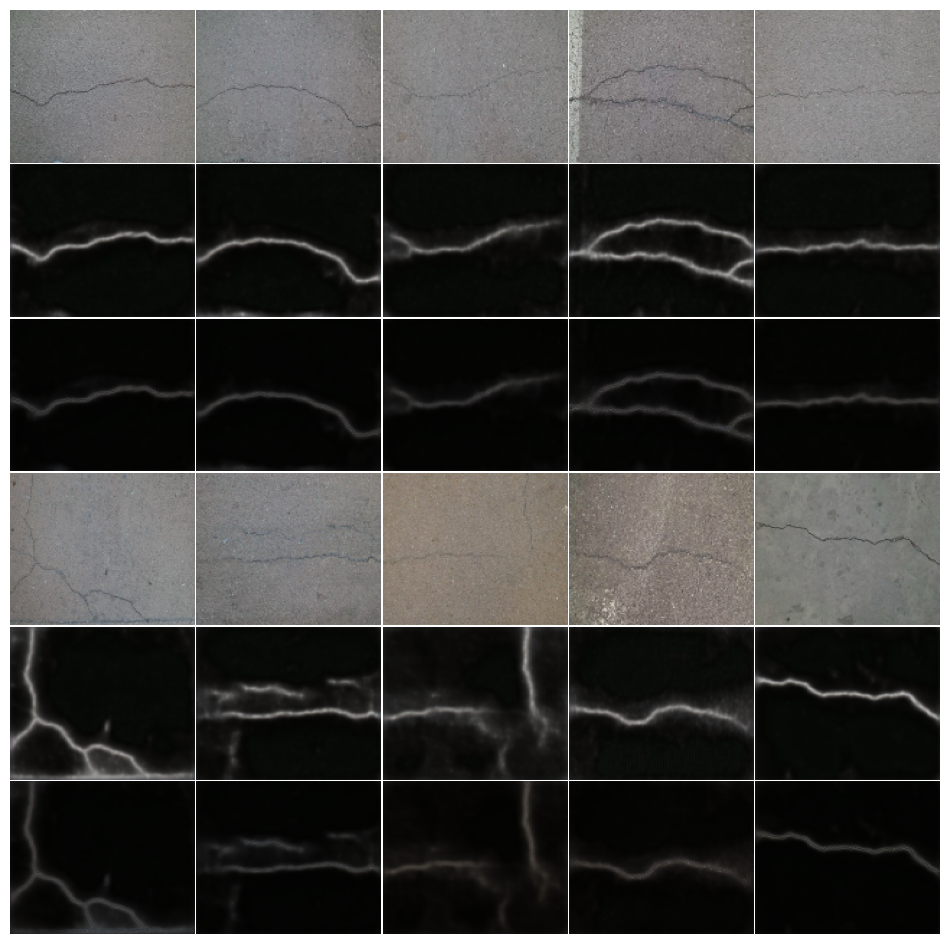

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.rcParams['figure.figsize'] = (12, 12)

# Create a new figure
plt.figure()
sns.set_style("whitegrid", {'axes.grid' : False})

# Set only vertical spacing to zero
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Iterate through each column
for i in range(5):
    # Plot the original images
    plt.subplot(6, 5, i + 1)
    plt.imshow(x_test[i], aspect='auto')
    plt.axis('off')

    # Plot the predicted masks
    plt.subplot(6, 5, i + 6)
    plt.imshow(preds[i], aspect='auto')
    plt.axis('off')

    # Plot the extracted masks
    plt.subplot(6, 5, i + 11)
    plt.imshow(x_test[i] * preds[i], aspect='auto')
    plt.axis('off')

    plt.subplot(6, 5, i + 16)
    plt.imshow(x_test[i+6], aspect='auto')
    plt.axis('off')

    # Plot the predicted masks
    plt.subplot(6, 5, i + 21)
    plt.imshow(preds[i+6], aspect='auto')
    plt.axis('off')

    # Plot the extracted masks
    plt.subplot(6, 5, i + 26)
    plt.imshow(x_test[i+6] * preds[i+6], aspect='auto')
    plt.axis('off')

plt.savefig('FOCAL_STUDENT.png', format='png', dpi=300)

plt.show()

# **Tversky Loss**

In [ ]:
from tensorflow import keras
from keras import layers

In [ ]:
from keras import layers

def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, (3,3), padding = "same", activation = "relu")(x)
   x = layers.Conv2D(n_filters, (3,3), padding = "same", activation = "relu")(x)
   x=keras.layers.BatchNormalization()(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x


In [ ]:
inputs = layers.Input(shape=(128,128,3))
f1, p1 = downsample_block(inputs, 8)
f2, p2 = downsample_block(p1, 16)
f3, p3 = downsample_block(p2, 32)
f4, p4 = downsample_block(p3, 64)

bottleneck = double_conv_block(p4, 128)

u6 = upsample_block(bottleneck, f4, 64)
u7 = upsample_block(u6, f3, 32)
u8 = upsample_block(u7, f2, 16)
u9 = upsample_block(u8, f1,8)

outputs1 = layers.Conv2D(3, 1, padding="same",activation='sigmoid',name='Output_1')(u9)
MODEL = keras.models.Model([inputs], [outputs1])

In [ ]:
from keras import backend as K
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
import keras.backend as K

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

LOG = keras.callbacks.CSVLogger('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Crack_Segment_UNet_TVERSKY.csv', separator=",", append=False)

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

import keras.backend as K

def pixel_wise_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def mean_pixel_accuracy(y_true, y_pred):
    class_accuracy = K.mean(K.cast(K.equal(K.round(y_true), K.round(y_pred)), dtype='float32'), axis=0)
    return K.mean(class_accuracy)

def intersection_over_union(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(iou, axis=-1)


import tensorflow as tf

def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1-((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

# Custom Focal Loss function
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Compute binary cross-entropy loss for each channel
    binary_ce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
    # Modify the loss for each channel
    focal_loss = alpha * (1 - tf.exp(-binary_ce)) ** gamma * binary_ce
    # Sum the loss across channels
    focal_loss = tf.reduce_sum(focal_loss, axis=-1)
    return tf.reduce_mean(focal_loss)

# Custom Tversky Loss function
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    true_positives = tf.reduce_sum(y_true * y_pred)
    false_positives = tf.reduce_sum((1 - y_true) * y_pred)
    false_negatives = tf.reduce_sum(y_true * (1 - y_pred))
    tversky = (true_positives + 1e-5) / (true_positives + alpha * false_positives + beta * false_negatives + 1e-5)
    return 1 - tversky

In [ ]:
MODEL.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=tversky_loss,
        metrics=[dice_coef, keras.metrics.Recall(), keras.metrics.Precision(), get_f1, pixel_wise_accuracy, intersection_over_union])

model_history = MODEL.fit(x_train, y_train, epochs=30, batch_size=16, validation_data=(x_test, y_test), callbacks = [LOG])

Epoch 1/30
313/313 [==============================] - 42s 63ms/step - loss: 0.7773 - dice_coef: 0.2731 - recall: 0.7328 - precision: 0.2191 - get_f1: 0.3504 - pixel_wise_accuracy: 0.8214 - intersection_over_union: 0.0361 - val_loss: 0.8875 - val_dice_coef: 0.1400 - val_recall: 0.4170 - val_precision: 0.3642 - val_get_f1: 0.2294 - val_pixel_wise_accuracy: 0.9421 - val_intersection_over_union: 0.0206
Epoch 2/30
313/313 [==============================] - 12s 39ms/step - loss: 0.4428 - dice_coef: 0.5553 - recall: 0.4850 - precision: 0.6955 - get_f1: 0.5818 - pixel_wise_accuracy: 0.9635 - intersection_over_union: 0.0265 - val_loss: 0.9172 - val_dice_coef: 0.1072 - val_recall: 0.3774 - val_precision: 0.6375 - val_get_f1: 0.2689 - val_pixel_wise_accuracy: 0.9682 - val_intersection_over_union: 0.0229
Epoch 3/30
313/313 [==============================] - 12s 39ms/step - loss: 0.3690 - dice_coef: 0.5965 - recall: 0.4418 - precision: 0.7901 - get_f1: 0.6005 - pixel_wise_accuracy: 0.9687 - interse

In [ ]:
MODEL.save('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Student_UNet_TVERSKY.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
preds = MODEL.predict(x_test[:50])

2/2 [==============================] - 2s 529ms/step


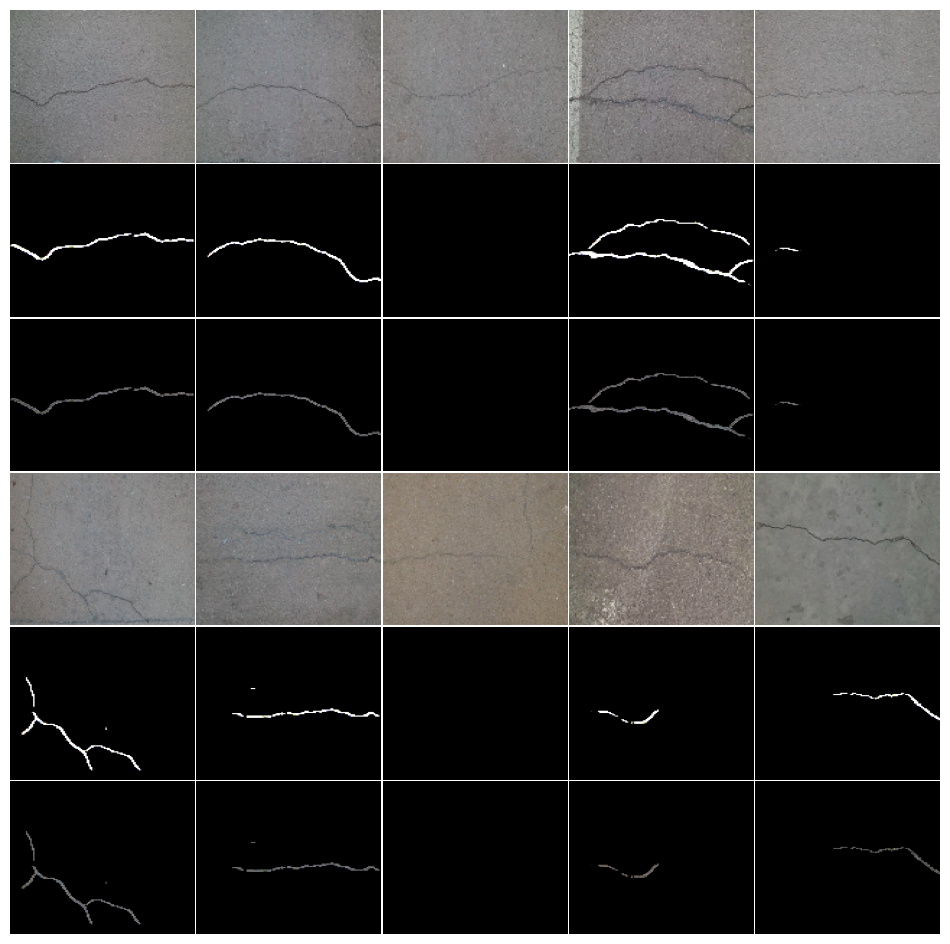

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.rcParams['figure.figsize'] = (12, 12)

# Create a new figure
plt.figure()
sns.set_style("whitegrid", {'axes.grid' : False})

# Set only vertical spacing to zero
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Iterate through each column
for i in range(5):
    # Plot the original images
    plt.subplot(6, 5, i + 1)
    plt.imshow(x_test[i], aspect='auto')
    plt.axis('off')

    # Plot the predicted masks
    plt.subplot(6, 5, i + 6)
    plt.imshow(preds[i], aspect='auto')
    plt.axis('off')

    # Plot the extracted masks
    plt.subplot(6, 5, i + 11)
    plt.imshow(x_test[i] * preds[i], aspect='auto')
    plt.axis('off')

    plt.subplot(6, 5, i + 16)
    plt.imshow(x_test[i+6], aspect='auto')
    plt.axis('off')

    # Plot the predicted masks
    plt.subplot(6, 5, i + 21)
    plt.imshow(preds[i+6], aspect='auto')
    plt.axis('off')

    # Plot the extracted masks
    plt.subplot(6, 5, i + 26)
    plt.imshow(x_test[i+6] * preds[i+6], aspect='auto')
    plt.axis('off')

plt.savefig('Tversky_STUDENT.png', format='png', dpi=300)

plt.show()

# **Performance Visualization**

In [ ]:
bce = pd.read_csv('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Crack_Segment_UNet_BCE.csv')
dice = pd.read_csv('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Crack_Segment_UNet_DICE.csv')
focal = pd.read_csv('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Crack_Segment_UNet_FOCAL.csv')
tversky = pd.read_csv('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Crack_Segment_UNet_TVERSKY.csv')

In [ ]:
bce.head()

epoch  dice_coef    get_f1  intersection_over_union      loss  \
0      0   0.139651  0.412784                 0.028166  0.478756   
1      1   0.279885  0.534888                 0.022741  0.163464   
2      2   0.385485  0.539449                 0.021414  0.112670   
3      3   0.436273  0.562842                 0.021944  0.099833   
4      4   0.458986  0.575296                 0.022379  0.094918   

   pixel_wise_accuracy  precision    recall  val_dice_coef  val_get_f1  \
0             0.894629   0.265316  0.474204       0.077378    0.077744   
1             0.965867   0.768319  0.375866       0.150251    0.216128   
2             0.966987   0.797347  0.373284       0.198675    0.209565   
3             0.968201   0.810875  0.394277       0.217008    0.241068   
4             0.968957   0.818133  0.407855       0.246259    0.258558   

   val_intersection_over_union  val_loss  val_pixel_wise_accuracy  \
0                     0.020073  0.652980                 0.612544   
1                     0.013824  0.149126                 0.966926   
2                     0.010911  0.099461                 0.972462   
3                     0.012569  0.100960                 0.972720   
4                     0.014314  0.091686                 0.973279   

   val_precision  val_recall  
0       0.070853    0.562741  
1       0.602233    0.268640  
2       0.859552    0.214397  
3       0.789854    0.278881  
4       0.784163    0.313366

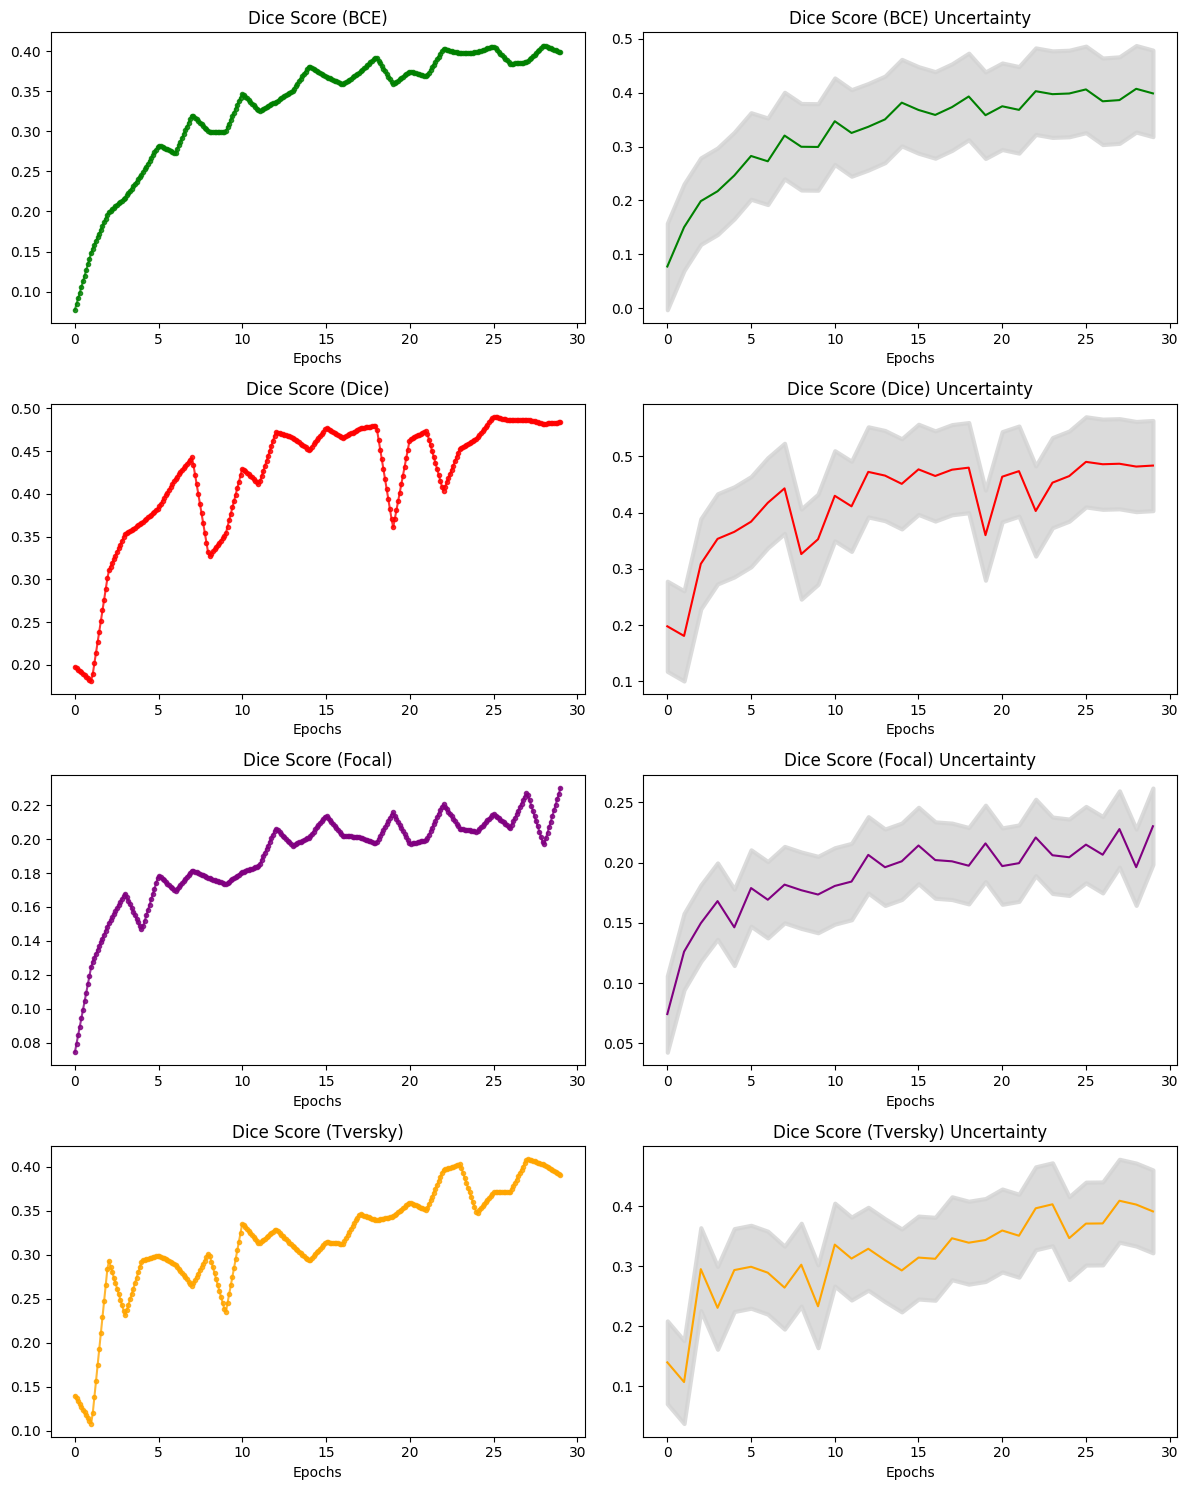

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated data (replace with your own data)
metrics = [ "Dice Score (BCE)", "Dice Score (Dice)", "Dice Score (Focal)", "Dice Score (Tversky)"]
DAAT = {
     "Dice Score (BCE)": bce['val_dice_coef'].to_list(),
    "Dice Score (Dice)": dice['val_dice_coef'].to_list(),
    "Dice Score (Focal)": focal['val_dice_coef'].to_list(),
    "Dice Score (Tversky)": tversky['val_dice_coef'].to_list()  # Add Precision data
}

# Define colors for each row
row_colors = ['green', 'red', 'purple', 'orange']  # Add a color for the new row

# Function to calculate Bayesian uncertainty
def calculate_uncertainty(data1):
    # Use statistical methods or Bayesian approaches to calculate uncertainty
    uncertainty = np.std(data1)  # Using standard deviation as an example
    return uncertainty

# Function to generate uncertainty bounds
def generate_uncertainty_bounds(metric_data, uncertainty_data):
    lower_bound = [metric - uncertainty_data for metric in metric_data]
    upper_bound = [metric + uncertainty_data for metric in metric_data]
    return lower_bound, upper_bound

# Create a figure with subplots
fig, axs = plt.subplots(4, 2, figsize=(12, 15))  # Extend the number of rows

for i, metric in enumerate(metrics):
    # Data for the current metric
    metric_data = DAAT[metric]

    # Calculate uncertainty for the current metric
    uncertainty_data = calculate_uncertainty(metric_data)

    # Generate uncertainty bounds for the current metric
    lower_bound, upper_bound = generate_uncertainty_bounds(metric_data, uncertainty_data)

    # Plot the original data with denser curve lines
    x_dense = np.linspace(0, len(metric_data) - 1, 10 * len(metric_data))  # Create denser x-axis values
    y_dense = np.interp(x_dense, range(len(metric_data)), metric_data)  # Interpolate for denser y-values
    axs[i, 0].plot(x_dense, y_dense, label=f"{metric}", color=row_colors[i % 5], marker='o', linestyle='-', markersize=3, alpha=0.8)
    axs[i, 0].set_title(f"{metric}")
    axs[i, 0].set_xlabel("Epochs")  # Add x-axis label

    # Plot the uncertainty with bounds as thicker lines with lighter color
    axs[i, 1].plot(range(len(metric_data)), metric_data, label=f"{metric}", color=row_colors[i % 5])
    axs[i, 1].fill_between(range(len(metric_data)), lower_bound, upper_bound, color='lightgrey', alpha=0.8, linewidth=3)
    axs[i, 1].set_title(f"{metric} Uncertainty")
    axs[i, 1].set_xlabel("Epochs")  # Add x-axis label

# Adjust layout
plt.tight_layout()

# Save the figure as a high-quality PNG
plt.savefig('Students_graphs.png', format='png', dpi=600)

# Show the figure
plt.show()
